In [1]:
import scipy.io
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as patches
from matplotlib.path import Path
import operator 

# Image I/O
import skimage.io
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
import scipy.misc
import Image, ImageOps

# Image Filtering
import scipy.ndimage.filters
import scipy.stats as st
import scipy.signal
import scipy.ndimage

%matplotlib inline

# Utilities

In [328]:
# Gaussian Filter
def gkern(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [2]:
# Display Images
def plot_1x2(img1, img2):
    fig = plt.figure(figsize = (20,10))
    ax1, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)
    ax1.imshow(img1, cmap='gray')
    ax2.imshow(img2, cmap='gray')

In [3]:
# Convert RGB images to Grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
# Validate element to be evaluated
def isvalid(new_x, new_y, x, y, max_x, max_y):
    if new_x < 0 or new_x >= max_x:
        return False
    elif new_y < 0 or new_y >= max_y:
        return False
    elif new_x == x and new_y == y:
        return False
    else:
        return True

In [635]:
# Extract patch around given coordinate
def extract_patch(pt, img, patch_size):
    patch = []
    x_slide = np.arange(-patch_size,patch_size+1)
    y_slide = np.arange(-patch_size,patch_size+1)
    img_x = int(pt[0])
    img_y = int(pt[1])
    
    # Assuming bounds are already validated
    for x in x_slide:
        tmp = []
        for y in y_slide:
            tmp.append(img[img_x+x, img_y+y])
        patch.append(tmp)
    return patch

In [5]:
# Plot corners on imgage
def draw_points(img, points):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    for elem in points:
        circ = Circle((elem[1], elem[0]),10)
        ax.add_patch(circ)
    plt.show()

In [539]:
# Concatenate images and draw lines between correct matches
def draw_lines(img1, img2, correct_matches):
    
    pad = img1.shape[0] - img2.shape[0]
    top1 = 0
    top2 = 0
    if pad > 0:
        top2 = pad
    elif pad < 0:
        top1 = abs(pad)
    
    new_img1 = cv2.copyMakeBorder(img1,top1,0,0,0,0,0)
    new_img2 = cv2.copyMakeBorder(img2,top2,0,0,0,0,0)
    
    offset = img1.shape[1]
    stack_img = np.hstack((new_img1, new_img2))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.imshow(stack_img, cmap='gray')
    codes = [Path.MOVETO,Path.LINETO]
    
    for match in correct_matches:
        verts = [(match[0][1], match[0][0]+top1), (match[1][1]+offset, match[1][0]+top2)]
        path = Path(verts, codes)
        ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))
    plt.show()

In [7]:
def plot_correspondence(img1, img2, cor1, cor2):
    
    offset = img1.shape[0] - img2.shape[0]
    img_shift = img1.shape[1]
    top1 = 0
    top2 = 0
    if offset > 0:
        top2 = offset
    elif offset < 0:
        top1 = abs(offset)
    
    new_img1 = cv2.copyMakeBorder(img1,top1,0,0,0,1,0)
    new_img2 = cv2.copyMakeBorder(img2,top2,0,0,0,1,0)
    
    stack_img = np.hstack((new_img1, new_img2))

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.imshow(stack_img, cmap='gray')
    codes = [Path.MOVETO,Path.LINETO]

    for elem in cor1:
        circ = Circle((elem[0], elem[1]+top1),10)
        ax.add_patch(circ)

    for elem in cor2:
        circ = Circle((elem[0]+img_shift, elem[1]+top2),10)
        ax.add_patch(circ)
    
    codes = [Path.MOVETO,Path.LINETO]
    for elem1, elem2 in zip(cor1, cor2):
        verts = [(elem1[0], elem1[1]+top1), (elem2[0]+img_shift, elem2[1]+top2)]
        path = Path(verts, codes)
        ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))
    plt.show()

# Load Data

In [8]:
dino_mat = scipy.io.loadmat('data/dino2.mat')
dino_01 = np.array(dino_mat['dino01'])
dino_02 = np.array(dino_mat['dino02'])
cor_01 = np.array(dino_mat['cor1'])
cor_02 = np.array(dino_mat['cor2'])

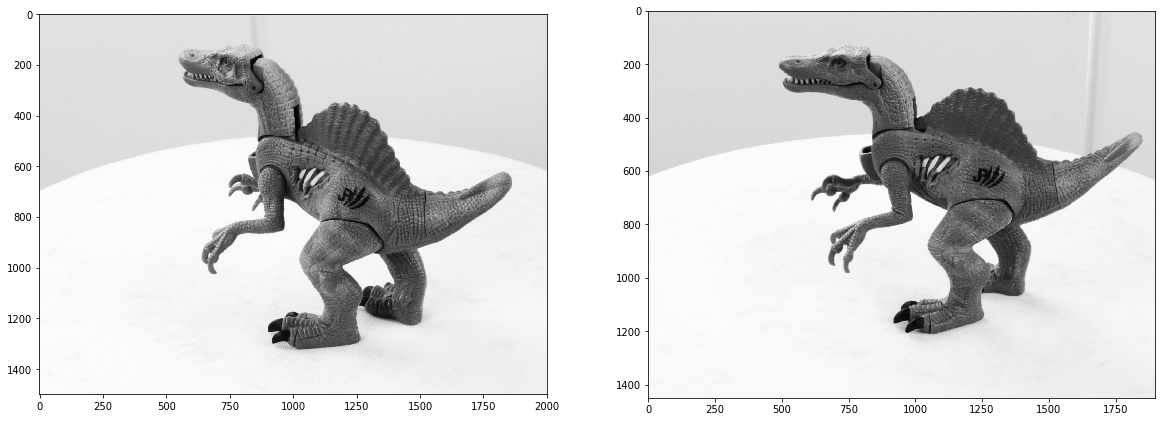

In [9]:
dino_01 = rgb2gray(dino_01)
dino_02 = rgb2gray(dino_02)
plot_1x2(dino_01, dino_02)

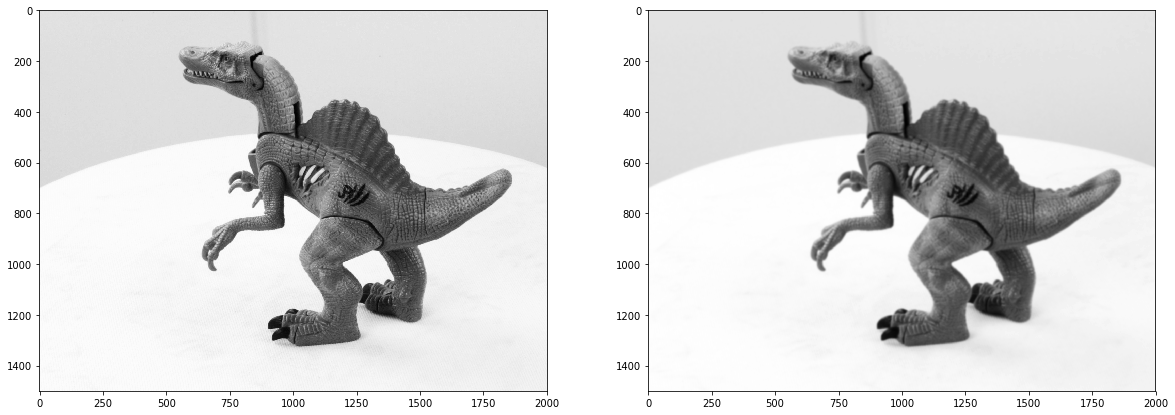

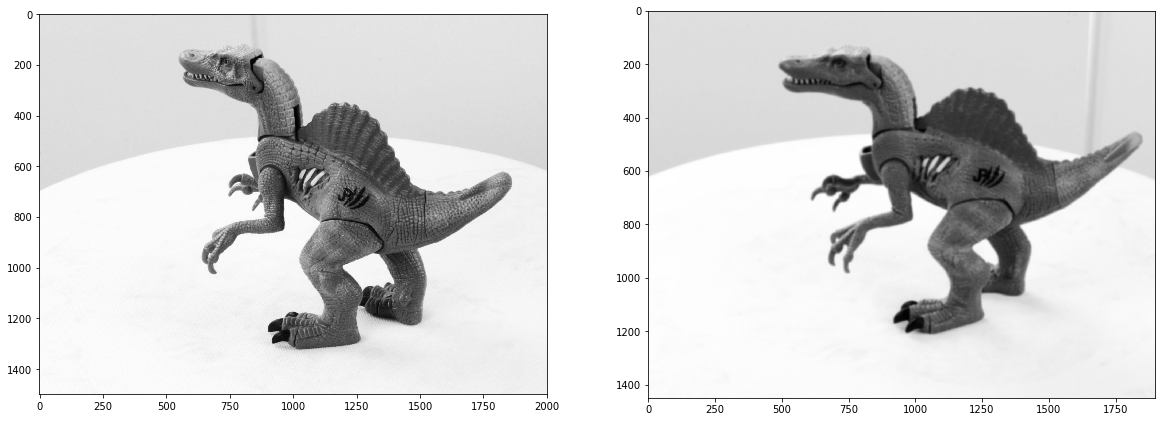

In [12]:
dino_01 = scipy.ndimage.filters.correlate(dino_01, gkern(21,5))
dino_02 = scipy.ndimage.filters.correlate(dino_02, gkern(21,5))
plot_1x2(dino_01, dino_02)

# Corner Detection

In [516]:
# Detect corners for dino_02 
def corner_detect(smooth_dino, num_corners):
    
    # Compute Gradients
    gradient_x = [[-1,0,1],[-1,0,1],[-1,0,1]] # gradient along x
    graident_y = [[-1,-1,-1],[0,0,0],[1,1,1]] # gradient along y

    I_x = scipy.ndimage.filters.correlate(smooth_dino, gradient_x)
    I_y = scipy.ndimage.filters.correlate(smooth_dino, graident_y)
    
    # Compute elements of C Matrix
    I_x2 = np.multiply(I_x, I_x)
    I_y2 = np.multiply(I_y, I_y)
    I_xy = np.multiply(I_x, I_y)

    row, col = img.shape
    C_min = np.zeros((row,col))
    C_max = np.zeros((row,col))

    # Store minimum eigen values in  separate matrix 
    for i in range(row):
        for j in range(col):
                C_min[i,j] = min(np.linalg.eigvals([[I_y2[i,j], I_xy[i,j]], [I_xy[i,j], I_x2[i,j]]]))
                C_max[i,j] = max(np.linalg.eigvals([[I_y2[i,j], I_xy[i,j]], [I_xy[i,j], I_x2[i,j]]])) 
                
    x_slide = [-1,0,1]
    y_slide = [-1,0,1]
    corners = []

    # For each pixel, choose the coordinate points of those that have 
    # largest min eigen value among neighbors   
    for i in range(row):
        for j in range(col):
            flag = True
            for x in x_slide:
                for y in y_slide:
                    if isvalid(i+x, j+y, i, j, row, col):
                        if C_min[i,j] < C_min[i+x,j+y]:
                            flag = False
            if flag == True:
                corners.append((i,j,C_min[i,j]))
                
    # Sort detected corners based on corner score
    corners.sort(key=operator.itemgetter(2), reverse=True)
    return corners[:num_corners]

# Stereo Correspondence Matching

In [522]:
# Number of corners to detect
num_corners = 200

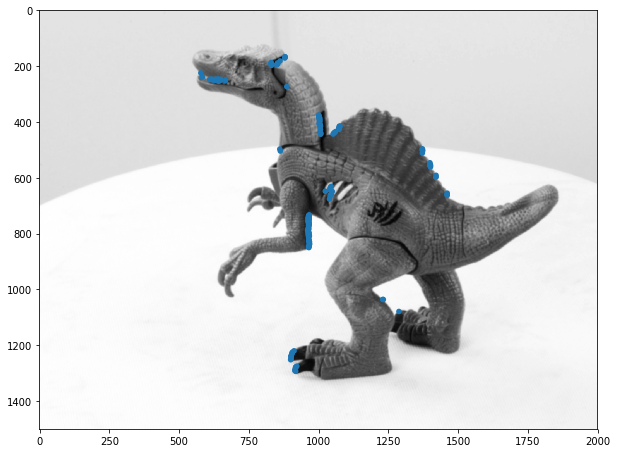

In [523]:
dino_01_corners = corner_detect(dino_01, num_corners)
draw_points(dino_01, dino_01_corners)

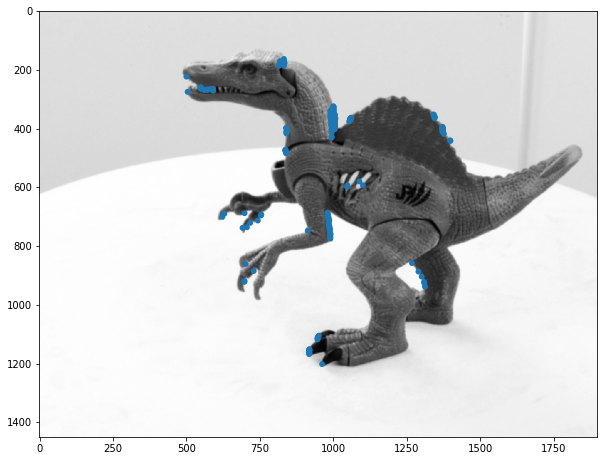

In [524]:
dino_02_corners = corner_detect(dino_02, num_corners)
draw_points(dino_02, dino_02_corners)

In [633]:
# Compute NSSD
def nssd(corner1, corner2, img1, img2, patch_size, thresh=0.0001):   
    # TODO: Check for corners in boundaries, Skipping now as there are no corners in boundaries   
    # Extract patch around corner and normalize
    cor1_mat = extract_patch(corner1, img1, patch_size)
    cor2_mat = extract_patch(corner2, img2, patch_size)
    norm_cor1 = normalize(cor1_mat)
    norm_cor2 = normalize(cor2_mat)
    
    # Return sum of squared differences 
    return sum(sum(np.subtract(norm_cor1,norm_cor2)**2))

In [629]:
def build_dist_matrix(corners_01, corners_02, img1, img2, patch_size=3):
    row, col = len(corners_01), len(corners_02)
    dist_mat = np.empty((row,col))
    for i in range(row):
        for j in range(col):
            dist_mat[i][j] = nssd(corners_01[i], corners_02[j], img1, img2, patch_size)
    return np.matrix(dist_mat)

In [592]:
def best_match_corner(dist_mat, corners_01, corners_02, ratio=0.6, thresh= 0.0001):
    used_col = []
    correct_matches = []
    
    # Iterate for each corner in image1
    for i in range(dist_mat.shape[0]):
        
        # Check if minimum distance between closest corner is at least ratio 
        # times smaller than the next closest corner
        min_row = np.sort(dist_mat[i])[0,:2]
        if min_row[0,0]/min_row[0,1] > ratio:
            continue
        
        # Repeat the same for matched corner in image2
        min_col_idx = dist_mat[i].argmin(1)
        min_col = np.sort(np.ravel(dist_mat[:,min_col_idx]))[:2]
        if min_col[0]/min_col[1] > ratio:
            continue
        
        # Qualify a perfect match if minimum along row and column are same 
        # and the corners have not been matched before
        if min_row[0,0] == min_col[0] and min_row[0,0] < thresh:
            if min_col_idx[0,0] not in used_col:
                correct_matches.append((corners_01[i], corners_02[min_col_idx[0,0]]))
                print i, min_col_idx[0,0], min_row[0,0]
                used_col.append(min_col_idx[0,0])
    print str(len(used_col)) + " matches"
    return correct_matches

In [638]:
patch_size = 5
dist_mat = build_dist_matrix(dino_01_corners, dino_02_corners, dino_01, dino_02, patch_size)

12 matches


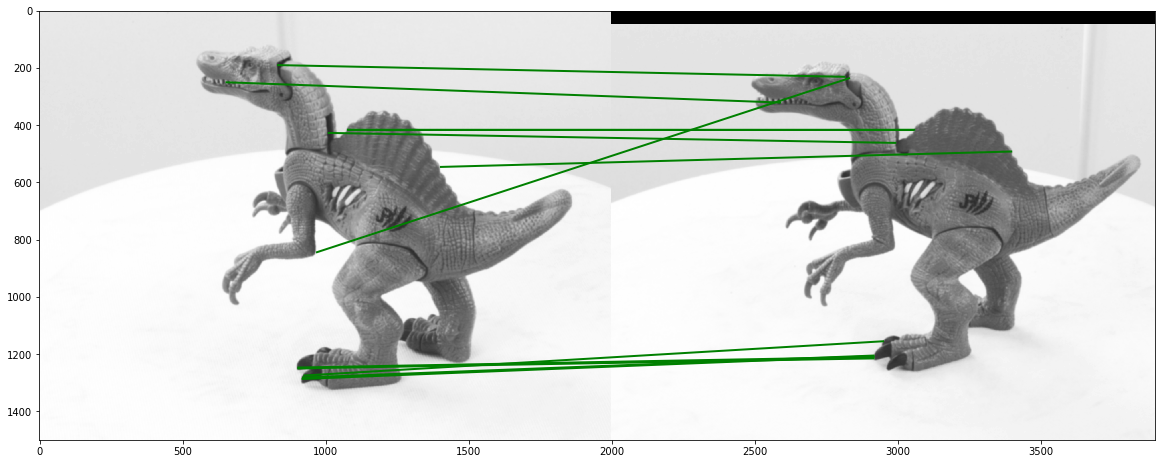

In [664]:
match_ratio = 0.70
dist_threshold = 0.015
correct_matches = best_match_corner(dist_mat, dino_01_corners, dino_02_corners, match_ratio, dist_threshold)
draw_lines(dino_01, dino_02, correct_matches)

# Fundamental Matrix Estimation

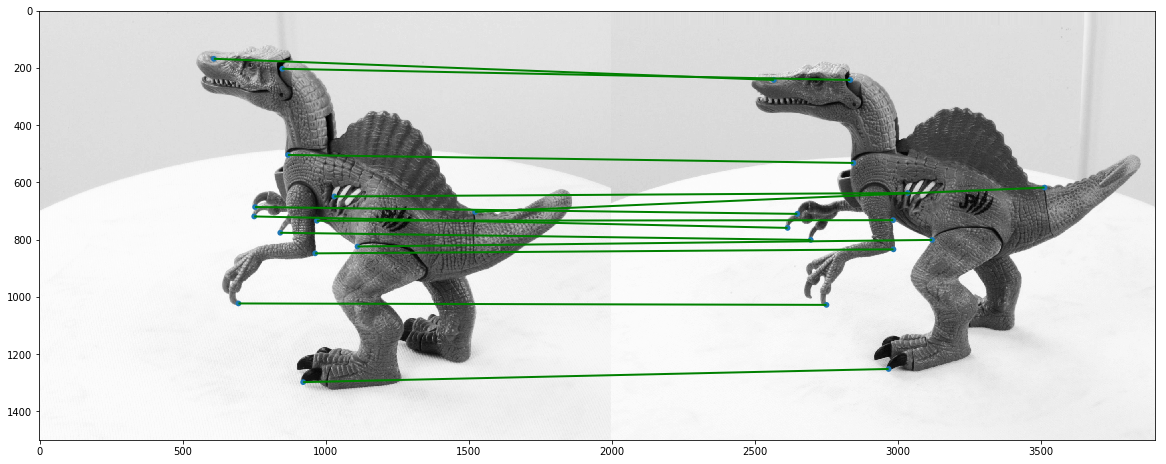

In [33]:
# Plot correspondence for matching corners
orig_dino_01 = rgb2gray(np.array(dino_mat['dino01']))
orig_dino_02 = rgb2gray(np.array(dino_mat['dino02']))
cor_01 = np.array(dino_mat['cor1'])
cor_02 = np.array(dino_mat['cor2'])
plot_correspondence(orig_dino_01, orig_dino_02, cor_01, cor_02)

In [34]:
def estimate_fundamental_matrix(cor1, cor2):
    # TODO: Elaborate DLT algorithm
    F, mask = cv2.findFundamentalMat(np.float32(cor1), np.float32(cor2), cv2.FM_8POINT)
    return F

In [35]:
# Compute fundamental matrix using corresponding points 
F = estimate_fundamental_matrix(cor_01, cor_02)

epipolar_lines = []
# Estimate epipolar line for each corner point. 
for cor in cor_01:
    x = np.hstack((cor,[1]))
    l = np.dot(F,x)
    epipolar_lines.append([l[0], l[1], l[2]])

# Epipolar Line for corresponding points

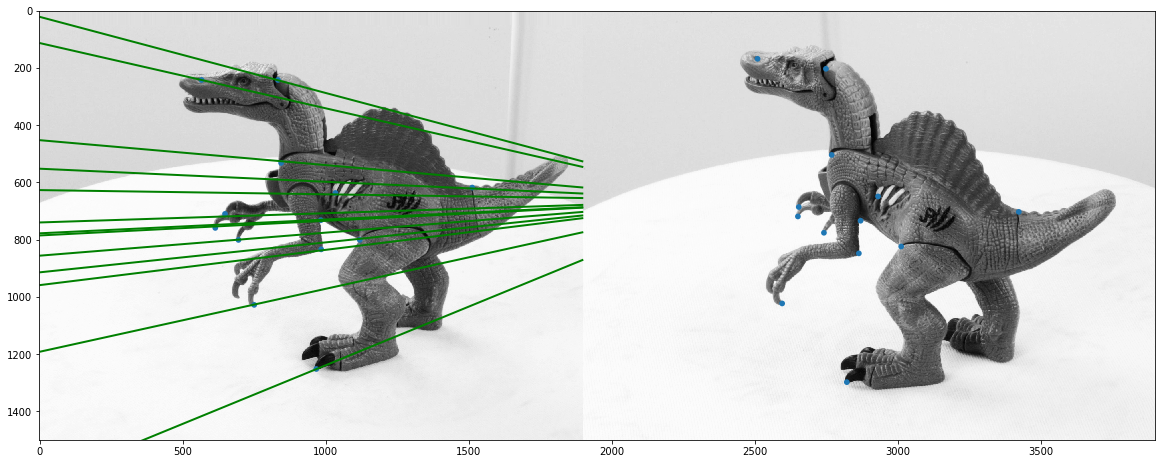

In [36]:
# Prepare image for plotting  
img1 = orig_dino_01
img2 = orig_dino_02

offset = img1.shape[0] - img2.shape[0]
img_shift = img2.shape[1]
top1 = 0
top2 = 0
if offset > 0:
    top2 = offset
elif offset < 0:
    top1 = abs(offset)
    
# Pad image to maintain same dimensions
new_img1 = cv2.copyMakeBorder(img1,top1,0,0,0,1,0)
new_img2 = cv2.copyMakeBorder(img2,top2,0,0,0,1,0)
stack_img = np.hstack((new_img2, new_img1))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.imshow(stack_img, cmap='gray')
codes = [Path.MOVETO,Path.LINETO]

# Plot all corners in stacked image
for elem in cor_02:
    circ = Circle((elem[0], elem[1]+top2),10)
    ax.add_patch(circ)   
    

for elem in cor_01:
    circ = Circle((elem[0]+img_shift, elem[1]+top1),10)
    ax.add_patch(circ)
    
codes = [Path.MOVETO,Path.LINETO]
for line in epipolar_lines:
    slope = -1*line[0]/line[1]
    intercept = -1*line[2]/line[1]
    verts = [(0, slope*0+intercept+top2), 
             (img_shift, slope*(img_shift)+intercept+top2)]
    path = Path(verts, codes)
    ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))

plt.show()

# Epipolar line for Random Points

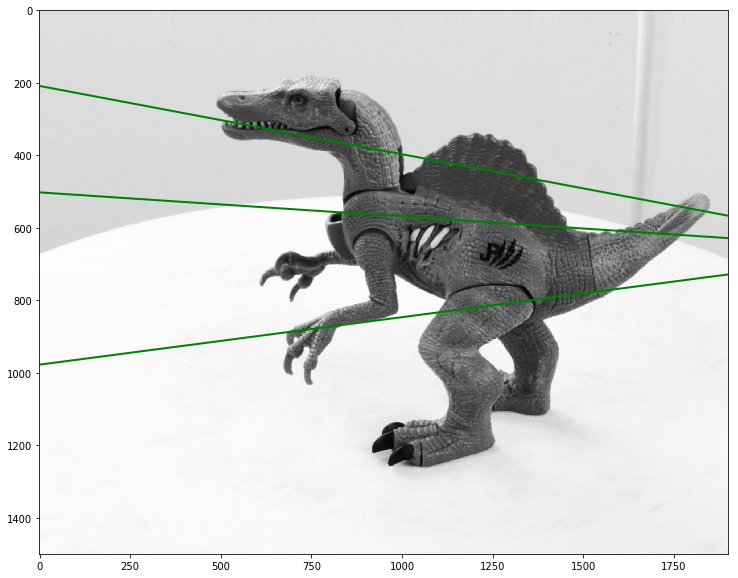

In [38]:
# Random homogenous points
rand_x = [[723, 860, 1],
     [679, 270, 1],
     [700, 500, 1]]

# Compute Epipolar lines for random points 
rand_epipolar_lines = []
for x in rand_x:
    l = np.dot(F,x)
    rand_epipolar_lines.append([l[0], l[1], l[2]])
    
# Prepare image for plotting  
img1 = orig_dino_01
img2 = orig_dino_02

offset = img1.shape[0] - img2.shape[0]
img_shift = img2.shape[1]
top1 = 0
top2 = 0
if offset > 0:
    top2 = offset
elif offset < 0:
    top1 = abs(offset)
    
# Pad image to maintain same dimensions
new_img1 = cv2.copyMakeBorder(img1,top1,0,0,0,1,0)
new_img2 = cv2.copyMakeBorder(img2,top2,0,0,0,1,0)
# stack_img = np.hstack((new_img2, new_img1))
stack_img = new_img2

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.imshow(stack_img, cmap='gray')
codes = [Path.MOVETO,Path.LINETO]

for elem in rand_x:
    circ = Circle((elem[0]+img_shift, elem[1]+top1),20)
    ax.add_patch(circ)
    
codes = [Path.MOVETO,Path.LINETO]
for line in rand_epipolar_lines:
    slope = -1*line[0]/line[1]
    intercept = -1*line[2]/line[1]
    verts = [(0, slope*0+intercept+top2), 
             (img_shift, slope*(img_shift)+intercept+top2)]
    path = Path(verts, codes)
    ax.add_patch(patches.PathPatch(path, color='green', lw=2.0))

plt.show()